# Image Processing with Deep Learning

Welcome to the third session of deep learning bootcamp.  Today we are going to focus on using deep learning for image processing.  Feel free to jot down any notes you have from today's session in this notebook and please feel free to modify and experiment with the code during today's exercises.

## What is Image Processing?

## Image Classification and LeNet

In [36]:
import torch
import torchvision
from matplotlib import pyplot as plt

Total No. Images: 60000
Sample of images with ground truth class data:


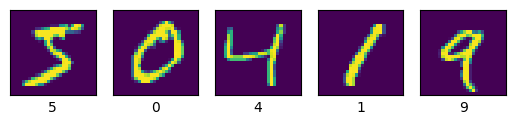

In [42]:
mnist = torchvision.datasets.MNIST(
    root='sample_data',
    download=True,
    transform=torchvision.transforms.ToTensor()
)
print(f'Total No. Images: {len(mnist)}')

print('Sample of images with ground truth class data:')
fig, ax = plt.subplots(1,5)
for i in range(5):
  ax[i].imshow(mnist[i][0].squeeze())
  ax[i].set_xlabel(mnist[i][1])
  ax[i].get_xaxis().set_ticks([])
  ax[i].get_yaxis().set_ticks([])


In [43]:
train_set, val_set, test_set = torch.utils.data.random_split(
    mnist,
    [int(0.8 * len(mnist)), int(0.1 * len(mnist)), int(0.1 * len(mnist))]
)
print(f'No. Train Images: {len(train_set)}')
print(f'No. Val Images: {len(val_set)}')
print(f'No. Test Images: {len(test_set)}')

No. Train Images: 48000
No. Val Images: 6000
No. Test Images: 6000


In [44]:
class LeNet(torch.nn.Module):

  def __init__(self):
    super().__init__()

    # First Convolution
    self.conv1 = torch.nn.Conv2d(
        in_channels=1,
        out_channels=4,
        kernel_size=5,
        stride=1,
        padding=0
    )
    self.batch_norm1 = torch.nn.BatchNorm2d(4)
    self.activation1 = torch.nn.ReLU()
    self.pool1 = torch.nn.MaxPool2d(2)

    # Second Convolution
    self.conv2 = torch.nn.Conv2d(
        in_channels=4,
        out_channels=12,
        kernel_size=5,
        stride=1,
        padding=0
    )
    self.batch_norm2 = torch.nn.BatchNorm2d(12)
    self.activation2 = torch.nn.ReLU()
    self.pool2 = torch.nn.MaxPool2d(2)

    # Fully Connected Layers
    self.fully_connected1 = torch.nn.Linear(
        in_features=4 * 4 * 12,
        out_features=10
    )
    self.softmax = torch.nn.LogSoftmax()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # First Convolution
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.activation1(x)
    x = self.pool1(x)

    # Second Convolution
    x = self.conv2(x)
    x = self.batch_norm2(x)
    x = self.activation2(x)
    x = self.pool2(x)

    # Head
    x = x.view(x.size(0), -1)
    x = self.fully_connected1(x)
    y_hat = self.softmax(x)
    return y_hat

In [45]:
# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = LeNet()
model.to(device)

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=200,
    shuffle=True,
    drop_last=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=200,
    shuffle=True,
    drop_last=True,
)

loss_function = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_loss = []
val_loss = []
for epoch in range(10):
  train_loss.append(0)
  val_loss.append(0)
  for data in train_loader:
    x, y = data
    x.to(device)
    y.to(device)
    y_hat = model(x)
    L = loss_function(y_hat, y)

    optimizer.zero_grad()
    L.backward()
    optimizer.step()

    train_loss[-1] += L

  for data in val_loader:
    x, y = data
    x.to(device)
    y.to(device)
    with torch.no_grad():
      y_hat = model(x)
      L = loss_function(y_hat, y)
      val_loss[-1] += L

  print(f'Epoch: {epoch} --- Training Loss: {train_loss[-1]:.2f} --- Val Loss: {val_loss[-1]:.2f}')



Using device: cpu


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 0 --- Training Loss: 418.39 --- Val Loss: 36.75
Epoch: 1 --- Training Loss: 225.00 --- Val Loss: 21.82
Epoch: 2 --- Training Loss: 145.10 --- Val Loss: 15.28
Epoch: 3 --- Training Loss: 105.86 --- Val Loss: 11.61
Epoch: 4 --- Training Loss: 82.63 --- Val Loss: 9.34
Epoch: 5 --- Training Loss: 67.75 --- Val Loss: 7.81
Epoch: 6 --- Training Loss: 57.58 --- Val Loss: 6.76
Epoch: 7 --- Training Loss: 50.18 --- Val Loss: 5.99
Epoch: 8 --- Training Loss: 44.63 --- Val Loss: 5.39
Epoch: 9 --- Training Loss: 40.30 --- Val Loss: 4.90


In [51]:
# Predict with model
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=200
)

loss_function = torch.nn.NLLLoss()

total_predictions = 0
total_correct = 0
for data in train_loader:
  x, y = data
  x.to(device)
  y.to(device)
  with torch.no_grad():
    y_hat = model(x)
    total_correct += torch.sum(torch.argmax(y_hat, 1) == y)
    total_predictions += y_hat.shape[0]

print(f'Accuracy: {100 * total_correct/total_predictions:.2f}%')


Accuracy: 96.02%


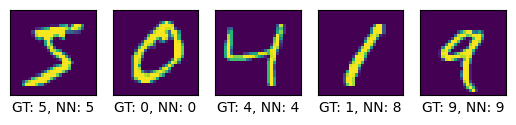

In [58]:
# Visualize Predictions
fig, ax = plt.subplots(1,5)
for i in range(5):
  ax[i].imshow(mnist[i][0].squeeze())

  with torch.no_grad():
    y_hat = model(mnist[i][0].unsqueeze(0))
    ax[i].set_xlabel(f'GT: {mnist[i][1]}, NN: {torch.argmax(y_hat, 1).item()}')

  ax[i].get_xaxis().set_ticks([])
  ax[i].get_yaxis().set_ticks([])

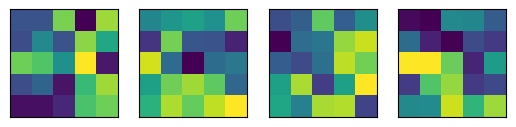

In [64]:
# Feature Visualization
fig, ax = plt.subplots(1,4)
for i in range(4):
  filter = model.conv1.weight[i,0,:,:].squeeze().detach().numpy()
  ax[i].imshow(filter)
  ax[i].get_xaxis().set_ticks([])
  ax[i].get_yaxis().set_ticks([])

